# MTLX as Collateral - Risk to Liquidity Providers
Date: 2022-02-03

Author: Matt McDonnell, Fetch.ai/Mettalex

This notebook is one of a series that explores use of MTLX governance tokens as collateral for the Mettalex DEX.  This would enable more use of the MTLX tokens and solve the problem of providing enough liquidity for traders to
open a position.  It should also hopefully provide buy pressure on the token price.

The situation we consider is one where traders buy position tokens for USD denominated stablecoins, while liquidity
providers (LPs) supply MTLX (or possibly MTLX/USD liquidity pool tokens) as collateral for the counterparty position.  
The core problem is that traders expect a USD denominated payoff from their position token, while MTLX LPs 
expect their original supplied MTLX to be returned with additional trading fees.  This results in an 
exchange rate risk between MTLX and USD.

In this notebook the focus is on what risks the Mettalex DEX liquidity providers are exposed to in terms of the
coin token backing pairs of position tokens.  A separate notebook `amm_mtlx_collateral_uniswap` then considers
what extra risks are incurred by the coin tokens themselves being backed by a mix of assets.

## Problem statement
Assume that we have almost balanced USD trading volume for long and short tokens, and the LP collateral is just needed to make up any imbalance.  For example, if we have \\$6M from traders buying long tokens and \\$4M from traders buying short tokens, how much MTLX collateral or MTLX/USD Uniswap liquidity is required?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import sympy as sp
from sympy.interactive import printing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interactive, interactive_output
from IPython import display

from tqdm.notebook import trange, tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
from amm import (
    default_simple_setup, default_compound_setup, simple_sim, default_compund_setup_2, 
    Simulation, AMM, UniswapPool, CompoundAmm, define_uniswap_deposit_single
)

In [5]:
from amm_simulation import (
    Simulator
)

In [6]:
printing.init_printing(use_latex=True)

In [7]:
x_c, x_l, x_s, w_c, w_l, w_s, v, C = sp.symbols(
    'x_c x_l x_s w_c w_l w_s v C', positive=True
)

In [8]:
x_p, x_d = sp.symbols('x_p x_d', positive=True)

In [9]:
amm_sym = default_simple_setup(x_c, x_p, x_p + x_d, v, C)
amm_sym.cumulative_tokens = [C*x_d*v, -x_d, 0] 

Firstly we consider a Mettalex DEX that contains coin, long and short tokens. Without loss of generality
we assume a possible excess of short tokens held by the DEX, i.e. there are more long buyers than short buyers.

Below we show the DEX balance denominated in coin, which is then broken down into:

* coin held, $x_c$, 
* pairs of long and short position tokens held, $x_p$, with each pair being backed by $C$ units of coin collateral
* excess short tokens held, $x_d$

Price of the asset in the trading band is denominated by $v$, ranging from 0 at the floor of the band to 1 at the 
cap of the band.

Below we show what the AMM state would look like assuming net $x_d$ long token has been bought from the AMM
for the fair value price of $vC$ per token.

In [10]:
amm_sym

AMM Balance: (C*x_d*x_p + C*x_p**2 + v*x_c*x_d + x_c*x_p)/(v*x_d + x_p)
 = C*x_p + x_c (safe) + C*x_d*x_p*(1 - v)/(v*x_d + x_p) (risk)
 = x_c coin
    + x_p long @ price C*v*(x_d + x_p)/(v*x_d + x_p)
      (value C*v*x_p*(x_d + x_p)/(v*x_d + x_p))
    + x_d + x_p short @ price C*x_p*(1 - v)/(v*x_d + x_p)
      (value C*x_p*(-v*x_d - v*x_p + x_d + x_p)/(v*x_d + x_p))
  Cumulative Trades:  Assets C*v*x_d  Maximum Liabilities C*x_d
  Trade Equity: C*v*x_d - C*x_d
  LP Token Price: 1

## Numerical Example


## Simulate Unbalanced Trades of Different Total Liquidity
Below we consider a Mettalex DEX containing initially 1M of liquidity split between 500k in coin and and 5000L, 5000S tokens.  Collateral backing a long and short token pair is 100 coin.

The underlying asset price is assumed to be in the middle of the band ($v=0.5$) and unchanging.

Trades of total value 100k coin (10% total liquidity), 200k coin, 500k coin are shown to demonstrate the effect 
of slippage on the trades.  Note that we assume the trading volume is split into 10 equal coin sized trades, which
results in each trade returning a different number of position tokens as the prices adjust.
We also assume an imbalanced total trading volue of 60% long, 40% short **in coin terms**.

At any time we can characterise the AMM state by:

* total balance: this is the total value of the AMM considering the amount of coin it owns, as well as long and short tokens valued at their spot price.
* safe balance: the amount of the total balance that is either coin or paired long and short tokens (that can always be converted back to underlying collateral).  This value won't change if underlying asset price changes.
* unsafe balance: value of unbalanced long and short tokens held.  This value **will** change if underlying asset price changes.

In addition we can consider the AMM position after a sequence of trades have been made against it.  Here we only consider traders buying long and short tokens:
* assets: coin that has been given to AMM in exchange for position tokens
* liabilities: coin that backs the AMM counterparty position.  We use a conservative valuation whereby each position token is valued at the full collateral value of the pair.
* equity: assets minus liabilities.

For each set of trades we also show the expected long and short token amounts that would be purchased at initial AMM spot value, and compare this with the actual amount of tokens received.

In [11]:
simulator = Simulator()
simulator.init_amm()

## Slippage vs Total Trade Volume

Total trading volume = 10% of AMM initial liquidity.  

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 50.00 (250000.00) + 5000.00 short @ 50.00 (250000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $60000.00 would purchase 1200.00 long tokens
At fair value $40000.00 would purchase 800.00 short tokens


AMM Balance: 1000642.36
 = 984321.66 (safe) + 16320.70 (risk)
 = 600000.00 coin + 3843.22 long @ 52.12 (200321.18) + 4184.11 short @ 47.88 (200321.18)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 197267.65
  Trade Equity: -97267.65
  LP Token Price: 1.00
Actual purchase 1156.78 long tokens (3.60% slippage)
Actual purchase 815.89 short tokens (-1.99% slippage)


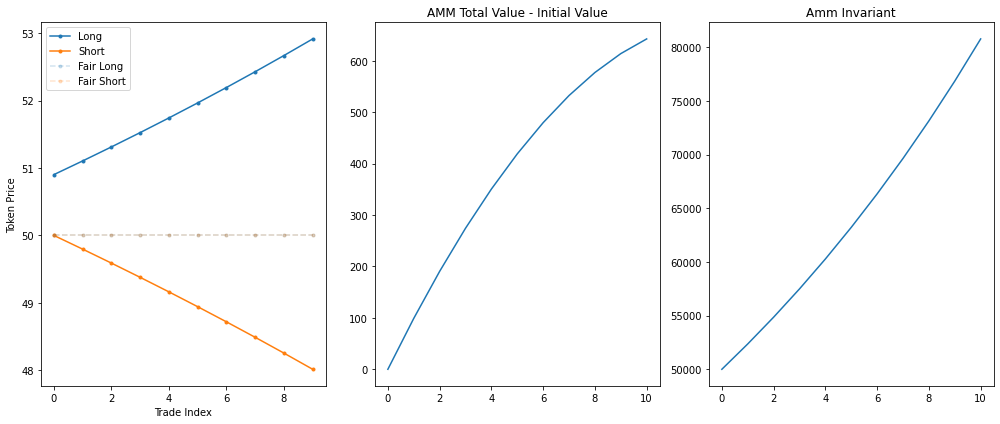

In [12]:
# Total trades 100,000 = 0.1 * initial AMM liquidity
# _ = simulate_trades(trades_long=60_000, trades_short=40_000, n_trades=10)
_ = simulator.simulate_trades()

Total trading volume = 20% of AMM initial liquidity.  

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 50.00 (250000.00) + 5000.00 short @ 50.00 (250000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $120000.00 would purchase 2400.00 long tokens
At fair value $80000.00 would purchase 1600.00 short tokens


AMM Balance: 1002692.70
 = 977487.62 (safe) + 25205.08 (risk)
 = 700000.00 coin + 2774.88 long @ 54.54 (151346.35) + 3329.34 short @ 45.46 (151346.35)
  Cumulative Trades:  Assets 200000.00  Maximum Liabilities 389578.21
  Trade Equity: -189578.21
  LP Token Price: 1.00
Actual purchase 2225.12 long tokens (7.29% slippage)
Actual purchase 1670.66 short tokens (-4.42% slippage)


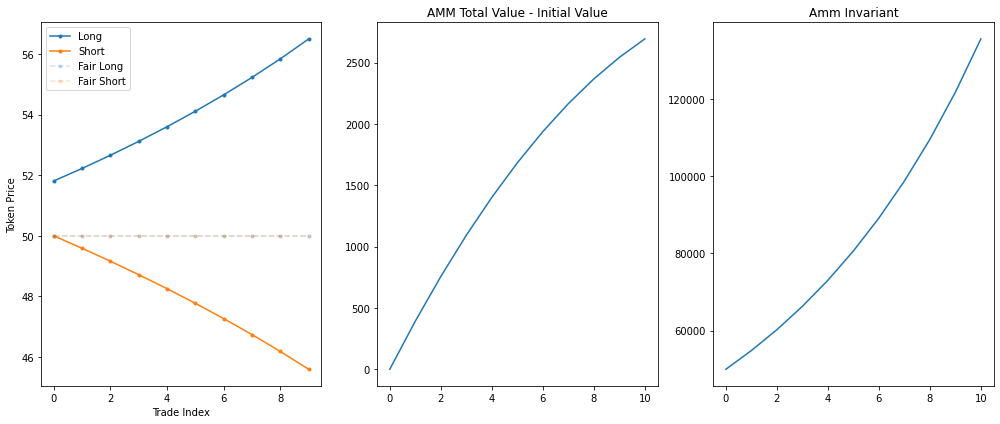

In [13]:
# Total trades 200,000 = 0.2 * initial AMM liquidity
_ = simulator.simulate_trades(trade_volume=200_000)
# _ = simulate_trades(trades_long=2*60_000, trades_short=2*40_000, n_trades=10)

Total trading volume = 50% of AMM initial liquidity.  

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 50.00 (250000.00) + 5000.00 short @ 50.00 (250000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $300000.00 would purchase 6000.00 long tokens
At fair value $200000.00 would purchase 4000.00 short tokens


AMM Balance: 1031333.53
 = 1027567.58 (safe) + 3765.95 (risk)
 = 1000000.00 coin + 275.68 long @ 56.83 (15666.77) + 362.91 short @ 43.17 (15666.77)
  Cumulative Trades:  Assets 500000.00  Maximum Liabilities 936141.23
  Trade Equity: -436141.23
  LP Token Price: 1.03
Actual purchase 4724.32 long tokens (21.26% slippage)
Actual purchase 4637.09 short tokens (-15.93% slippage)


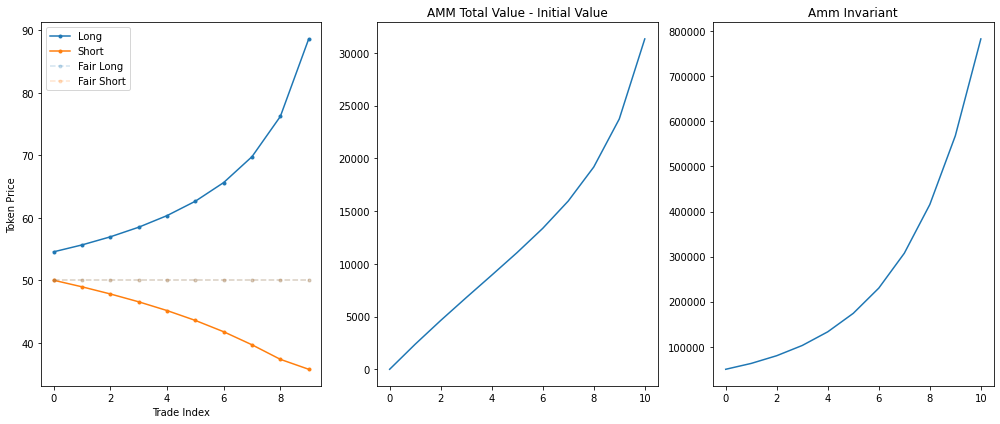

In [14]:
# Total trades 500,000 = 0.5 * initial AMM liquidity
_ = simulator.simulate_trades(trade_volume=500_000)

## Trades at high asset price
Below we consider trades where the underlying asset price has increased above the mid-band value.
For $v=0.6$ the 60%/40% split in coin value of long and short trades matches the token prices, so 
equal amounts of long and short tokens are bought and prices remain in line.

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 60.00 (300000.00) + 5000.00 short @ 40.00 (200000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $60000.00 would purchase 1000.00 long tokens
At fair value $40000.00 would purchase 1000.00 short tokens


AMM Balance: 1001038.67
 = 1000236.66 (safe) + 802.01 (risk)
 = 600000.00 coin + 4015.75 long @ 59.92 (240623.20) + 4002.37 short @ 40.08 (160415.47)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 198188.20
  Trade Equity: -98188.20
  LP Token Price: 1.00
Actual purchase 984.25 long tokens (1.58% slippage)
Actual purchase 997.63 short tokens (0.24% slippage)


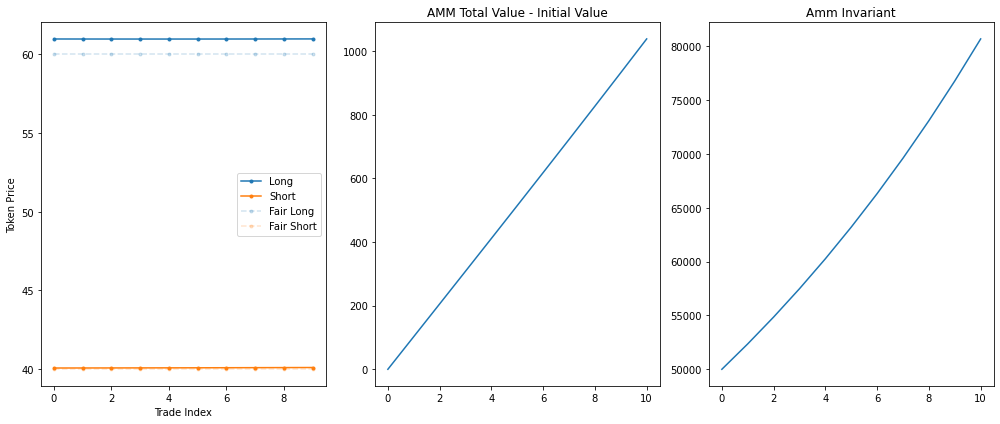

In [15]:
_ = simulator.simulate_trades(price=0.6)

# _ = simulate_trades(trades_long=60_000, trades_short=40_000, n_trades=10, v=0.6)

We consider now underlying asset price greater than the trade imbalance, 
i.e. $v > 0.6$ in the case of 60% Long and 40% Short.

It can be seen that the Short buyers start to drive the Short prices up enough that there's actually negative slippage for Long buyers.

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 80.00 (400000.00) + 5000.00 short @ 20.00 (100000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $60000.00 would purchase 750.00 long tokens
At fair value $40000.00 would purchase 2000.00 short tokens


AMM Balance: 998214.64
 = 920156.27 (safe) + 78058.36 (risk)
 = 600000.00 coin + 4240.63 long @ 75.12 (318571.71) + 3201.56 short @ 24.88 (79642.93)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 255781.06
  Trade Equity: -155781.06
  LP Token Price: 1.00
Actual purchase 759.37 long tokens (-1.25% slippage)
Actual purchase 1798.44 short tokens (10.08% slippage)


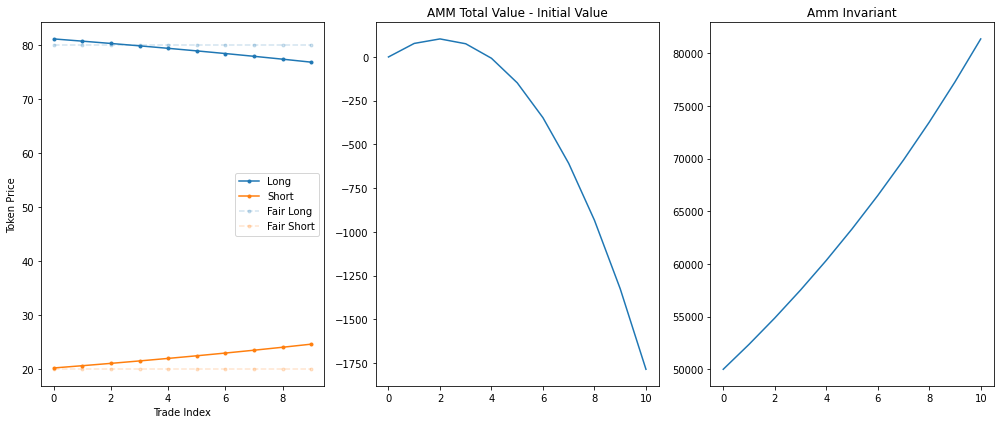

In [16]:
_ = simulator.simulate_trades(price=0.8)

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 90.00 (450000.00) + 5000.00 short @ 10.00 (50000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $60000.00 would purchase 666.67 long tokens
At fair value $40000.00 would purchase 4000.00 short tokens


AMM Balance: 988122.47
 = 803812.79 (safe) + 184309.68 (risk)
 = 600000.00 coin + 4314.77 long @ 80.96 (349310.22) + 2038.13 short @ 19.04 (38812.25)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 364710.50
  Trade Equity: -264710.50
  LP Token Price: 0.99
Actual purchase 685.23 long tokens (-2.78% slippage)
Actual purchase 2961.87 short tokens (25.95% slippage)


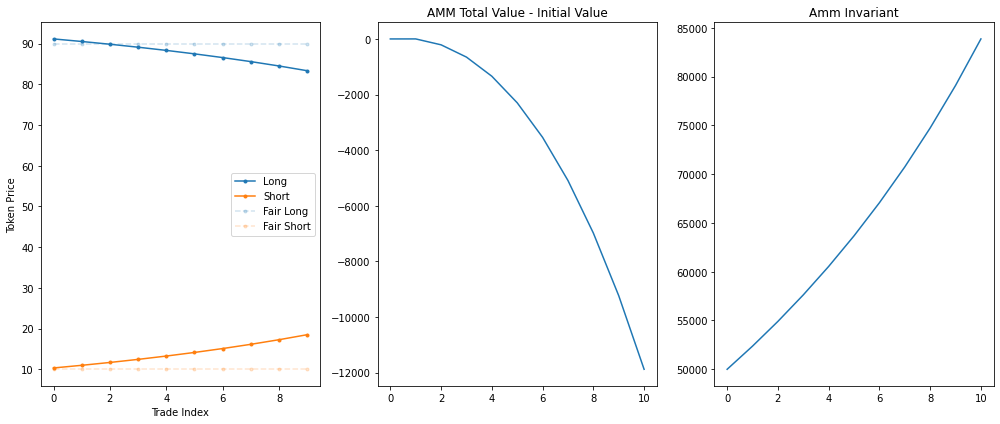

In [17]:
_ = simulator.simulate_trades(price=0.9)

# _ = simulate_trades(trades_long=60_000, trades_short=40_000, n_trades=10, v=0.9)

## Trades at low asset prices
Here we consider trades at underlying asset prices $v \lt 0.5$.  We see that the lower cost of Long
tokens means a given coin Long buy amount results in  more higher slippage.

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 40.00 (200000.00) + 5000.00 short @ 60.00 (300000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $60000.00 would purchase 1500.00 long tokens
At fair value $40000.00 would purchase 666.67 short tokens


AMM Balance: 999324.62
 = 959746.21 (safe) + 39578.41 (risk)
 = 600000.00 coin + 3597.46 long @ 44.40 (159729.85) + 4309.31 short @ 55.60 (239594.77)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 209322.50
  Trade Equity: -109322.50
  LP Token Price: 1.00
Actual purchase 1402.54 long tokens (6.50% slippage)
Actual purchase 690.69 short tokens (-3.60% slippage)


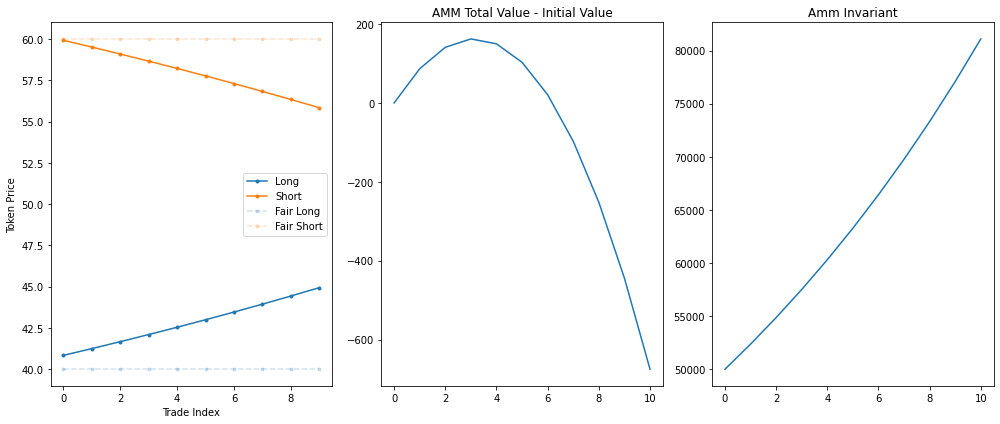

In [18]:
_ = simulator.simulate_trades(price=0.4)

# _= simulate_trades(trades_long=60_000, trades_short=40_000, n_trades=10, v=0.4)

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 20.00 (100000.00) + 5000.00 short @ 80.00 (400000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $60000.00 would purchase 3000.00 long tokens
At fair value $40000.00 would purchase 500.00 short tokens


AMM Balance: 989614.67
 = 857714.12 (safe) + 131900.55 (risk)
 = 600000.00 coin + 2577.14 long @ 30.24 (77922.93) + 4467.81 short @ 69.76 (311691.73)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 295504.46
  Trade Equity: -195504.46
  LP Token Price: 0.99
Actual purchase 2422.86 long tokens (19.24% slippage)
Actual purchase 532.19 short tokens (-6.44% slippage)


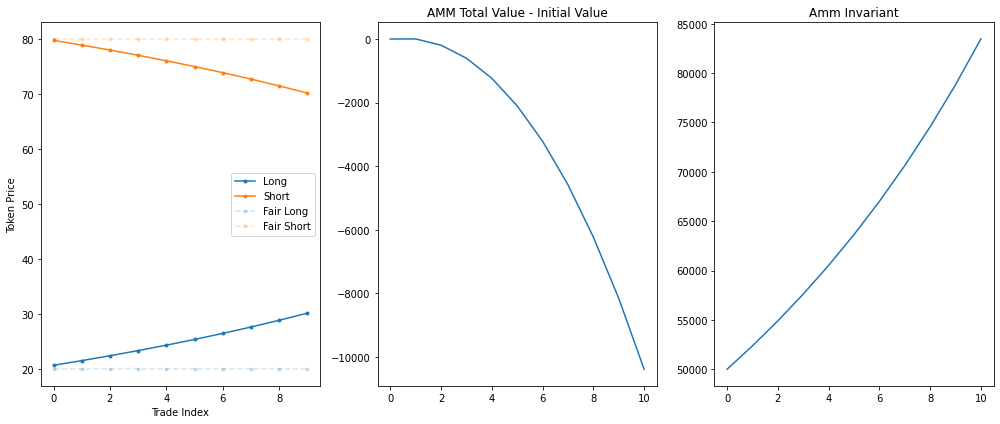

In [19]:
_ = simulator.simulate_trades(price=0.2)

# _ = simulate_trades(trades_long=60_000, trades_short=40_000, n_trades=10, v=0.2)

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 10.00 (50000.00) + 5000.00 short @ 90.00 (450000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $60000.00 would purchase 6000.00 long tokens
At fair value $40000.00 would purchase 444.44 short tokens


AMM Balance: 961533.05
 = 729648.96 (safe) + 231884.10 (risk)
 = 600000.00 coin + 1296.49 long @ 27.89 (36153.31) + 4511.99 short @ 72.11 (325379.75)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 419152.04
  Trade Equity: -319152.04
  LP Token Price: 0.96
Actual purchase 3703.51 long tokens (38.27% slippage)
Actual purchase 488.01 short tokens (-9.80% slippage)


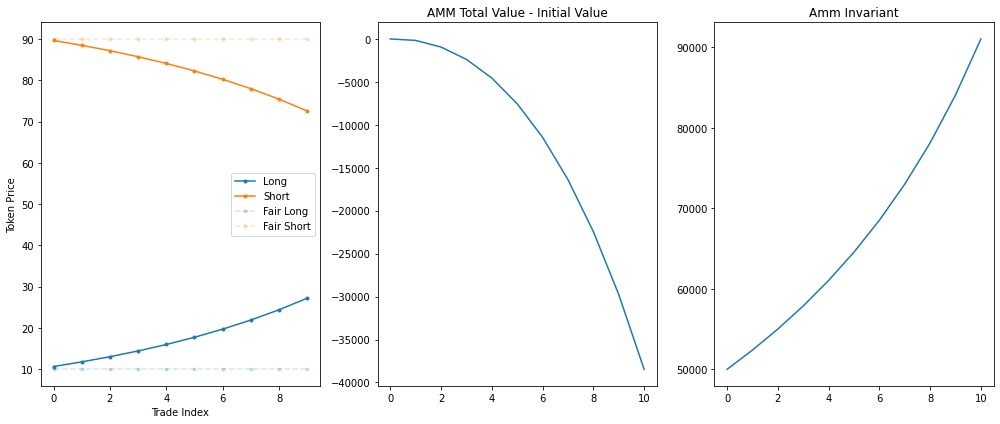

In [20]:
_ = simulator.simulate_trades(price=0.1)

# _ = simulate_trades(trades_long=60_000, trades_short=40_000, n_trades=10, v=0.1)

## Imbalanced trades opposite to band position
Below we consider an asset trading near the bottom of the band at $v = 0.1$ and most of the order flow going to 
purchase of long tokens.  This could happen for example if the asset price is range bound and traders expect 
a rebound in price.

AMM Balance: 1000000.00
 = 1000000.00 (safe) + 0.00 (risk)
 = 500000.00 coin + 5000.00 long @ 10.00 (50000.00) + 5000.00 short @ 90.00 (450000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 1.00
At fair value $90000.00 would purchase 9000.00 long tokens
At fair value $10000.00 would purchase 111.11 short tokens


AMM Balance: 882551.18
 = 659250.63 (safe) + 223300.55 (risk)
 = 600000.00 coin + 592.51 long @ 47.69 (28255.12) + 4861.09 short @ 52.31 (254296.06)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 454640.21
  Trade Equity: -354640.21
  LP Token Price: 0.88
Actual purchase 4407.49 long tokens (51.03% slippage)
Actual purchase 138.91 short tokens (-25.02% slippage)


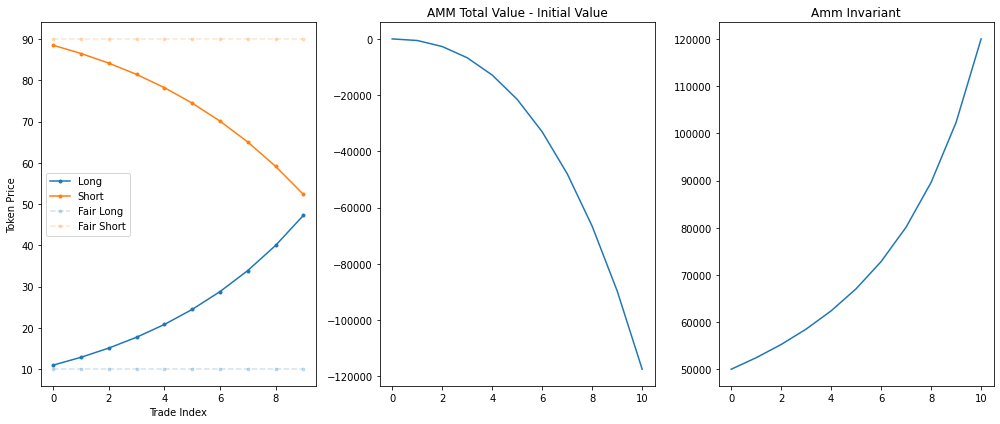

In [21]:
_ = simulator.simulate_trades(price=0.1, f_long=0.9)

# _ = simulate_trades(trades_long=90_000, trades_short=10_000, n_trades=10, v=0.1)

# AMM Performance from Liquidity Provider Perspective
Below we consider the LP perspective of trades against AMM.  Firstly we look at the value of the LP tokens 
after a given trading volume for fixed underling asset price.

We see that an imbalance in trading volume between long and short buyers results in a shift of the region where 
LPs experience a positive return.  This region is around where the trade imbalance matches the position of the underlying asset within the trading band.

**To Investigate**: if AMM has trade imbalance that does not match the underlying asset position then adjust the relative slippage for buying long and short tokens by minting or redeeming position token pairs for a particular trading position.  
For example if underlying asset price is $v = 0.5$ and we observe 60:40 long:short buyers the AMM could attempt to incentivise equal buyers by (virtually) mint L + S from coin tokens for new long buys (increasing slippage since coin fraction is reduced) or (virtually) redeem L + S token pairs for coin for new short buys (decreasing slippage). 

In [22]:
# _ = plt.plot(range(n_trades+1), tot_val- tot_val[0,0])
# _ = plt.legend(v_range)

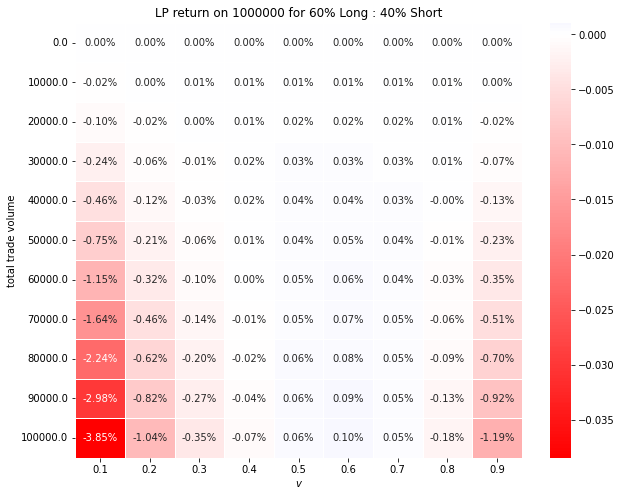

In [23]:
_ = simulator.lp_pnl_map()

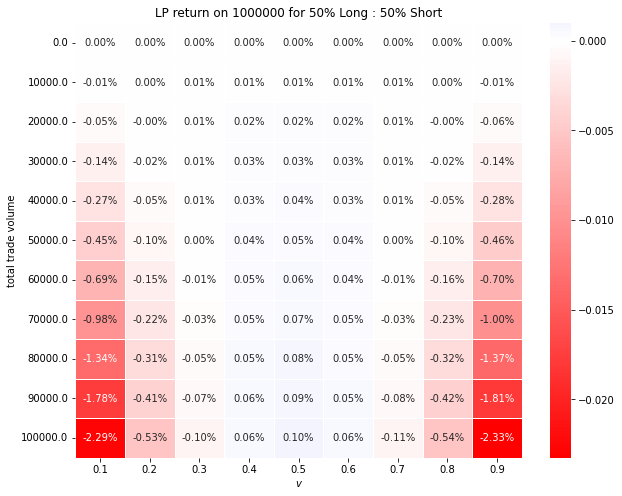

In [24]:
_ = simulator.lp_pnl_map(f_long=0.5)

We now consider an initial liquidity of 10M coin and total trading volume of 3M split 60:40 between long and short buyers.

We see that away from the balanced trading section the AMM is at risk of running out of liquidity.

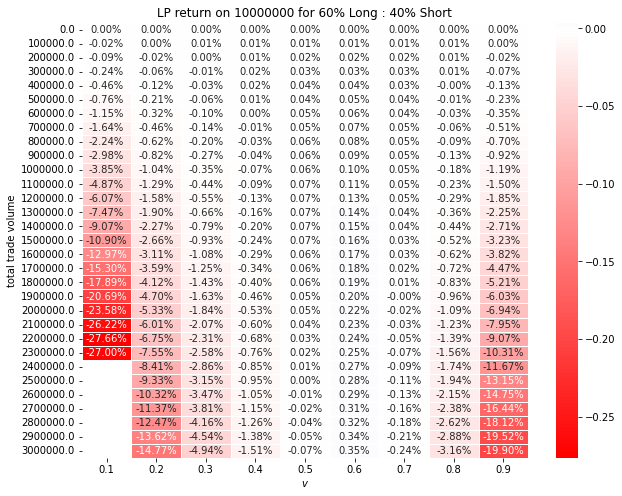

In [25]:
simulator.initial_liquidity = 10_000_000
simulator.reset_amm()
_ = simulator.lp_pnl_map(f_long=0.6, trade_volume=3_000_000, n_trades=30, field='total value')

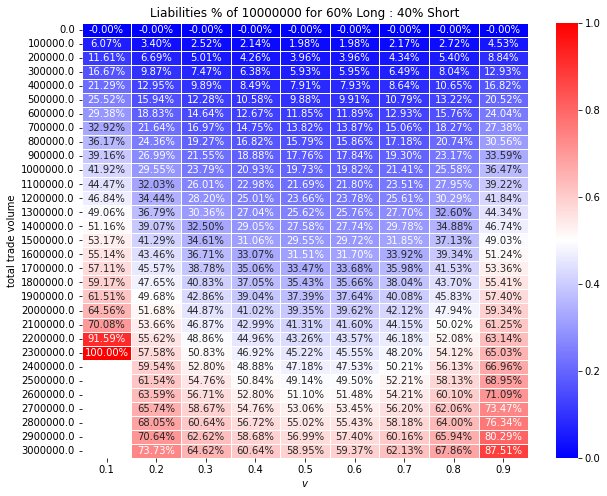

In [26]:
simulator.initial_liquidity = 10_000_000
simulator.reset_amm()
_ = simulator.lp_pnl_map(f_long=0.6, trade_volume=3_000_000, n_trades=30, field='liabilities')

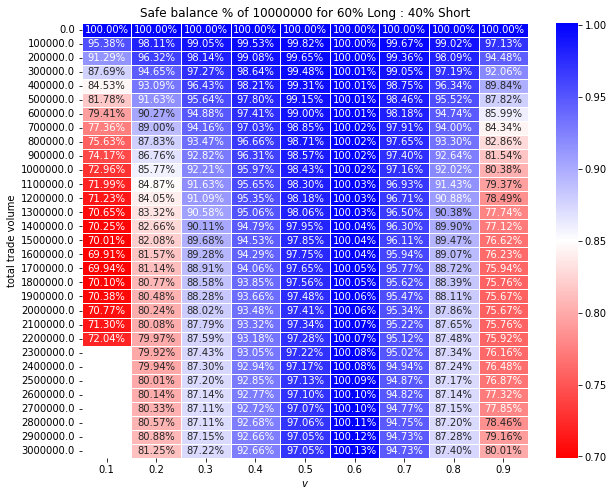

In [27]:
simulator.initial_liquidity = 10_000_000
simulator.reset_amm()
_ = simulator.lp_pnl_map(f_long=0.6, trade_volume=3_000_000, n_trades=30, field='safe')

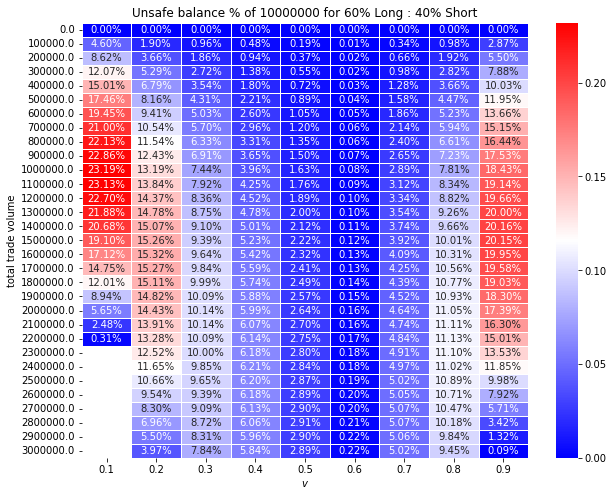

In [28]:
simulator.initial_liquidity = 10_000_000
simulator.reset_amm()
_ = simulator.lp_pnl_map(f_long=0.6, trade_volume=3_000_000, n_trades=30, field='unsafe')

## Changing Split Between Coin and Position Tokens
Up to now we have assumed that the initial liquidity is split 50% coin, 50% Long and Short tokens.  

Below we consider the effect of changing this split, e.g. keeping less in coin to reduce the slippage of 
trading position tokens.

We can see that the slippage is reduced at the expense of increasing the liabilities, which may rise to >100% of
initial liquidity.  This could raise counterparty risk issues. However note that these liabilities are calculated in a conservative way that assumes the AMM may need to pay out both a Long token and Short token at full collateral value, and in practice liability >100% would just mean that the AMM is unable to repurchase position tokens at fair value.

AMM Balance: 10000000.00
 = 10000000.00 (safe) + 0.00 (risk)
 = 2500000.00 coin + 75000.00 long @ 50.00 (3750000.00) + 75000.00 short @ 50.00 (3750000.00)
  Cumulative Trades:  Assets 0.00  Maximum Liabilities -0.00
  Trade Equity: 0.00
  LP Token Price: 10.00
At fair value $60000.00 would purchase 1200.00 long tokens
At fair value $40000.00 would purchase 800.00 short tokens


AMM Balance: 10000110.17
 = 9980381.02 (safe) + 19729.14 (risk)
 = 2600000.00 coin + 73803.81 long @ 50.13 (3700055.08) + 74199.45 short @ 49.87 (3700055.08)
  Cumulative Trades:  Assets 100000.00  Maximum Liabilities 199673.91
  Trade Equity: -99673.91
  LP Token Price: 10.00
Actual purchase 1196.19 long tokens (0.32% slippage)
Actual purchase 800.55 short tokens (-0.07% slippage)


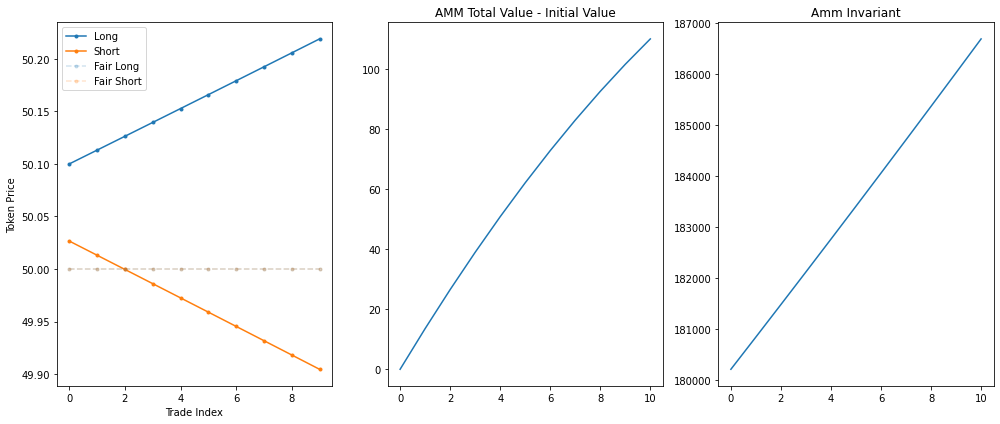

In [29]:
simulator.reset_amm(coin_fraction=0.25)
_ = simulator.simulate_trades()

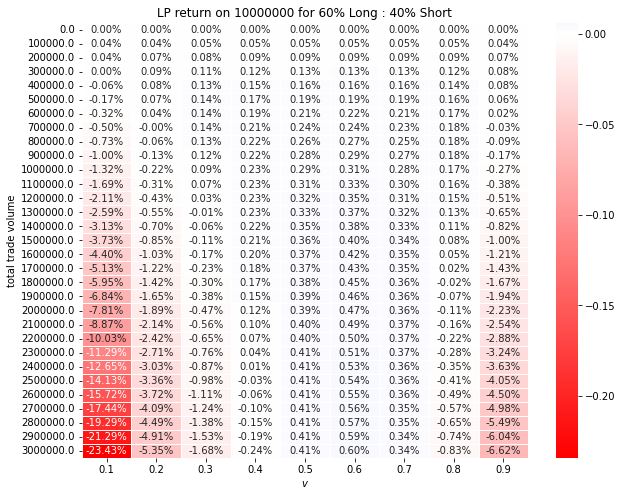

In [30]:
simulator.initial_liquidity = 10_000_000
simulator.reset_amm(coin_fraction=0.05)
_ = simulator.lp_pnl_map(f_long=0.6, trade_volume=3_000_000, n_trades=30, field='total value')

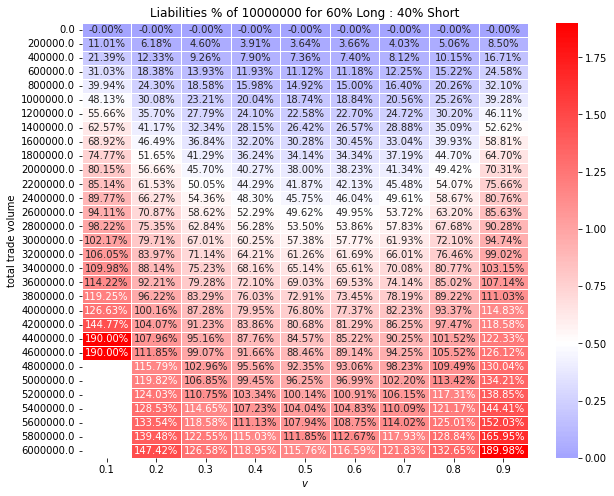

In [31]:
simulator.initial_liquidity = 10_000_000
simulator.reset_amm(coin_fraction=0.05)
_ = simulator.lp_pnl_map(f_long=0.6, trade_volume=6_000_000, n_trades=30, field='liabilities')

# MTLX as collateral
We consider MTLX use as collateral to back the creation of position token pairs for incoming USD trades.  

In [32]:
# Uniswap 
x, y, f, ps, ks, v = sp.symbols('x y f p k, v', positive=True)
d_x, d_y = sp.symbols('delta_x delta_y', positive=True)
x, y, f, ps, ks, d_x, d_y, v

In [33]:
k = x*y
sp.Eq(ks, k)

In [34]:
p = x/y
sp.Eq(ps, p)

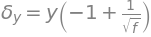

In [35]:
# Amount of y to swap to pool to reduce price to f*p, f<1
sp.Eq(
    d_y, 
    sp.solve(f*p - p.subs({x: x - d_x, y: y + d_y}).subs(
        sp.solve([(k.subs({x: x - d_x, y: y + d_y})).expand() - k,], d_x)
    ).simplify(), d_y)[0].collect(y))

In [36]:
# Amount of x to swap to pool to increase price to f*p, f>1
sp.Eq(
    d_x, 
    sp.solve(f*p - p.subs({x: x + d_x, y: y - d_y}).subs(
        sp.solve([(k.subs({x: x + d_x, y: y - d_y})).expand() - k,], d_y)
    ).simplify(), d_x)[0].collect(x))

In [37]:
# Initial position: trader buys L for vC USD, LP buys S for (1-v)C/p MTLX
d, m, C, p_0, ps, v_usd, v_mtlx, ds, ms = sp.symbols('d m C p_0 p v_$ v_m d m', positive=True)
d = v*C   # Amount of dollars backing long position
m = (1-v)*C/p_0  # Amount of MTLX backing short position
pf_usd = ds + ps*ms  
sp.Eq(v_usd, pf_usd)  # Overall position value in dollars

v_$ = d + m⋅p

In [38]:
pf_mtlx = ds/ps + ms
sp.Eq(v_mtlx, pf_mtlx)

In [39]:
initial_state = {ds: v*C, ps: p_0}
init_m = sp.solve(pf_usd.subs(initial_state) - C, ms, dict=True)[0]
init_m

In [40]:
pf_usd.subs(initial_state).subs(init_m).simplify()

In [41]:
v_usd_f = sp.Eq(v_usd, pf_usd.subs({ds: v*C}).subs(init_m))
v_mtlx_f = sp.Eq(v_mtlx, pf_mtlx.subs({ds: v*C}).subs(init_m))
v_usd_f, v_mtlx_f

⎛      C⋅p⋅(1 - v)             C⋅(1 - v)   C⋅v⎞
⎜v_$ = ─────────── + C⋅v, vₘ = ───────── + ───⎟
⎝           p₀                     p₀       p ⎠

Collateral value in USD and MTLX if MTLX price starts at \\$1 and drops to \\$0.5

In [42]:
v_usd_f.subs({p_0: 1, ps: .5, v: 0.2, C:100})

v_$ = 60.0

In [43]:
v_mtlx_f.subs({p_0: 1, ps: .5, v: 0.2, C:100})

Collateral value in USD and MTLX if MTLX price starts at \\$1 and increases to \\$2

In [44]:
v_usd_f.subs({p_0: 1, ps: 2, v: 0.2, C:100})

v_$ = 180.0

In [45]:
v_mtlx_f.subs({p_0: 1, ps: 2, v: 0.2, C:100})

# FRAX
Consider using a fractional collateralization approach similar to FRAX, whereby a stablecoin is minted from a mix of collateral and governance token.


## Minting
Needs to satisfy 

  $F = P_y Y + P_z Z$, 
  
  and $(1-C_r) P_y Y = C_r P_z Z$, 
  
where $F$ is number of FRAX minted, $Y$ is number of units of collateral, $Z$ is number of units of FXS governance token, $P_i$ is price of token $i$ and $C_r$ is collateral ratio

## Burning
Needs to satisfy same equations, solving for $Y$ and $Z$ now.


In [46]:
Fs, Y, Z = sp.symbols('F, Y, Z', nonnegative=True)
P_y, P_z, C_r = sp.symbols('P_y, P_z, C_r', positive=True)
Fs, Y, Z, P_y, P_z, C_r

In [47]:
F = P_y*Y + P_z*Z
val_cons = sp.Eq(Fs, F)
val_cons

In [48]:
mint_cons = sp.Eq((1-C_r)*P_y*Y, C_r*P_z*Z)
mint_cons

In [49]:
state = {C_r: 0.8, P_y: 1, P_z:2, Y:120}
sol_z = sp.solve(mint_cons.subs(state), Z, dict=True)[0]
sp.Eq(Z, Z.subs(sol_z)), val_cons.subs(state).subs(sol_z)

In [50]:
# Example for Mettalex: e.g. MTLX price of $0.5, 50% collateral ratio 
state = {C_r: 0.5, P_y: 1, P_z:.5, Y:50}
sol_z = sp.solve(mint_cons.subs(state), Z, dict=True)[0]
sp.Eq(Z, Z.subs(sol_z)), val_cons.subs(state).subs(sol_z)